In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

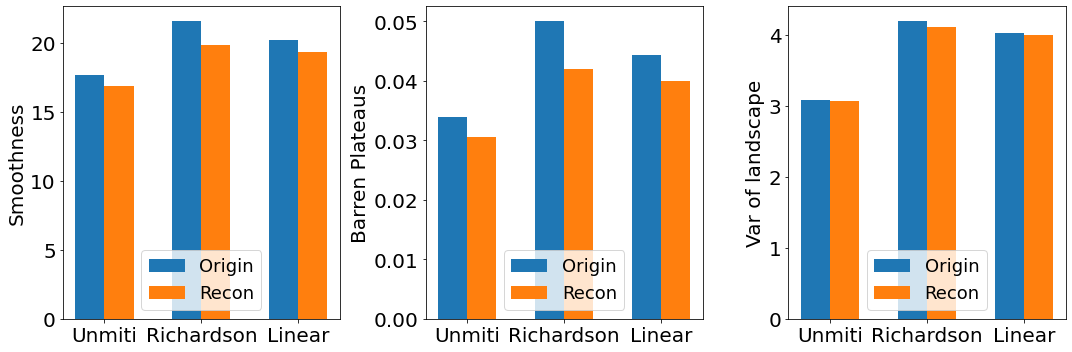

In [35]:
def vis_metric(ax, metric_name: str, labels: list, origin: list, recon: list):
    # bbox = dict(facecolor='yellow', pad=5, alpha=0.2)

    xs = np.array(range(len(labels)))
    bar_width = 0.3
    ax.bar(xs, origin, width=bar_width, label='Origin') #, color="r")
    ax.bar(xs+bar_width, recon, width=bar_width, label='Recon') #, color="b")
    # axs[0].xticks(xs + bar_width/2, labels)
    ax.set_xticks(xs + bar_width/2)
    ax.set_xticklabels(labels)
    ax.set_ylabel(metric_name) #, bbox=bbox)
    ax.legend(loc='lower center')


params = {'legend.fontsize': 18,
          'figure.figsize': (15, 5),
         'axes.labelsize': 20, #'x-large',
         'axes.titlesize': 20, #'x-large',
         'xtick.labelsize': 20,
         'ytick.labelsize': 20}
plt.rcParams.update(params)

fig, axs = plt.subplots(nrows=1, ncols=3)
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
# plt.legend()
# plt.show()

vis_metric(
    axs[0],
    "Smoothness",
    labels = ["Unmiti", "Richardson", "Linear"],
    origin = [17.67519336,	21.55886429,	20.20787102],
    recon = [16.89841502,	19.83555727, 19.31832727],
)

vis_metric(
    axs[1],
    "Barren Plateaus",
    labels = ["Unmiti", "Richardson", "Linear"],
    origin = [0.03396575118,	0.05001929258,	0.04439624263],
    recon = [0.03062864831,	0.04203118462,	0.04003329766]
    
)


vis_metric(
    axs[2],
    "Var of landscape",
    labels = ["Unmiti", "Richardson", "Linear"],
    origin = [3.083008726,	4.188213885,	4.029826627],
    recon = [3.061404465,	4.105587744,	4.001657739] 
)

# axs[0].legend(loc=2)
# fig.align_ylabels(axs)
fig.tight_layout()
# axs[1].tight_layout()
# fig.subplots_adjust(wspace=0.3)
fig.savefig("paper_figs/miti_preserve.pdf", bbox_inches="tight", dpi=1000)

In [ ]:
a = np.array([2, 8, 15, 13, 15], dtype=float)
np.gradient(a)

In [ ]:

def _vis_landscapes(
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None,
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    # plt.figure
    # plt.rc('font', size=28)
    if len(landscapes) == 2:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
    elif len(landscapes) == 3:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    elif len(landscapes) == 4:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    else:
        assert False

    fig.suptitle(title)
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'])

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(labels[idx])
        axs[idx].set_xlabel('beta')
        axs[idx].set_ylabel('gamma')
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker = '*'
                markersize = 15

            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged solution")

            axs[idx].legend()

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))])
    # plt.legend()
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close('all')

In [ ]:
def compare_with_ideal_landscapes(ideal, ls1, ls2):
    diff1 = ideal - ls1   # Richardson factory
    diff2 = ideal - ls2   # linear factory

    ids = np.abs(diff1) < np.abs(diff2)     # indices that Richardson is closer to ideal than linear
    
    print("\ntotal points on the landscape:")
    print(np.sum(ids))

    print("\n# qubits that landscape-1 is closer to ideal:")
    print(np.sum(ids == True))
    # print(np.sum(ids == False))
    
    print("\nvar of diff:")
    print(np.var(diff1))
    print(np.var(diff2))

    print("\nvar of abs diff")
    print(np.var(np.abs(diff1)))
    print(np.var(np.abs(diff2)))



In [ ]:
 
def vis_case_compare_mitigation_method():

    # derive origin full landscape
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()
    miti1 = origin['mitis']

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()
    miti1_recon = recon['mitis']

    data2_dir = "figs/gen_p1_landscape/2022-10-08_16:52:53/G40_nQ8_p1_depolar0.001_0.005_zneLinear"
    miti2 = np.load(f"{data2_dir}/data.npz", allow_pickle=True)['origin'].tolist()['mitis']
    recon2_path = f"{data2_dir}/2D_CS_recon_sf0.050.npz"
    miti2_recon = np.load(recon2_path, allow_pickle=True)['recon'].tolist()['mitis']

    # params_paths = [opt_data2['params_path'].tolist(), opt_data2['params_path'].tolist(), opt_data1['params_path']]

    # find some points where Richardson Factory is closer

    ideal = origin['ideals']

    # recon.
    # diff1 = ideal - miti1_recon   # Richardson factory
    # diff2 = ideal - miti2_recon   # linear factory
    

    print("----- compare with original landscape -------")
    compare_with_ideal_landscapes(ideal, miti1, miti2)

    print("----- compare with original landscape -------")
    compare_with_ideal_landscapes(ideal, miti1_recon, miti2_recon)

    _vis_landscapes(
        # landscapes=[origin['unmitis'], miti1, miti2, miti1_recon, miti2_recon],
        landscapes=[miti1, miti2, miti1_recon, miti2_recon],
        labels=["ZNE RichardsonFactory", "ZNE LinearFactory", "ZNE RichardsonFactory Recon", "ZNE LinearFactory Recon"],
        full_range=full_range,
        true_optima=None,
        title="Compare different ZNE configs and reconstruction",
        save_path="paper_figs/case3.png",
        params_paths=[None, None, None, None]
    )
vis_case_compare_mitigation_method()

In [ ]:
 
from data_loader import get_recon_landscape, get_recon_pathname


def vis_case_compare_mitigation_method_n16():
    is_reconstructed = True 
    is_test = check

    method = 'sv'
    problem = 'maxcut'
    miti_method1 = 'zne-LinearFactory'
    miti_method2 = 'zne-RichardsonFactory'

    # noise-3
    p1 = 0.001
    p2 = 0.02
    n_qubits = 16

    noise = f'depolar-{p1}-{p2}'

    # n_qubits = 16
    cs_seed = n_qubits
    p = 1
    sf = 0.05
    seed = 0
    if p == 2:
        bs = 12
        gs = 15
    elif p == 1:
        bs = 50
        gs = 100
    else:
        raise ValueError("Invalid depth of QAOA")
    miti1_data, miti1_data_fname, _ = load_grid_search_data(
        n_qubits=n_qubits, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method1
    )
    miti1 = miti1_data['data']
    # mitigation_method1 = miti1_data['mitigation_method']
    # mitigation
    print(miti1_data['mitigation_method'], miti1_data['mitigation_config'])
    # print(mitigation_config1)

    # exit()
    recon1_path, _, _ = get_recon_pathname(p, problem, method, noise, cs_seed, sf, miti1_data_fname)
    # recon1_path = f"figs/recon_p2_landscape/{timestamp}/recon-sf={sf:.3f}-cs_seed={cs_seed}-{miti1_data_fname}"
    miti1_recon = get_recon_landscape(p, miti1, sf, is_reconstructed, recon1_path, cs_seed)

    # -------- derive miti2 data

    print("\n\n")

    miti2_data, miti2_data_fname, _ = load_grid_search_data(
        n_qubits=n_qubits, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed, miti_method=miti_method2
    )
    miti2 = miti2_data['data']

    recon2_path, _, _ = get_recon_pathname(p, problem, method, noise, cs_seed, sf, miti2_data_fname)
    # recon2_path = f"figs/recon_p2_landscape/{timestamp}/recon-sf={sf:.3f}-cs_seed={cs_seed}-{miti2_data_fname}"
    miti2_recon = get_recon_landscape(p, miti2, sf, is_reconstructed, recon2_path, cs_seed)
    
    print(miti2_data['mitigation_method'], miti2_data['mitigation_config'])

    # params_paths = [opt_data2['params_path'].tolist(), opt_data2['params_path'].tolist(), opt_data1['params_path']]

    # find some points where Richardson Factory is closer

    # recon.
    # diff1 = ideal - miti1_recon   # Richardson factory
    # diff2 = ideal - miti2_recon   # linear factory
    

    print("----- compare with original landscape -------")
    compare_with_ideal_landscapes(ideal, miti1, miti2)

    print("----- compare with original landscape -------")
    compare_with_ideal_landscapes(ideal, miti1_recon, miti2_recon)

    _vis_landscapes(
        # landscapes=[origin['unmitis'], miti1, miti2, miti1_recon, miti2_recon],
        landscapes=[miti1, miti2, miti1_recon, miti2_recon],
        labels=["ZNE RichardsonFactory", "ZNE LinearFactory", "ZNE RichardsonFactory Recon", "ZNE LinearFactory Recon"],
        full_range=full_range,
        true_optima=None,
        title="Compare different ZNE configs and reconstruction",
        save_path="paper_figs/case3.png",
        params_paths=[None, None, None, None]
    )
vis_case_compare_mitigation_method()

In [ ]:
def vis_recon_error():
    # diff1 = {'L2-norm': 30.804969647723908, 'MSE': 0.2738246568786238, '1-NCC': 0.0010727892143963524, 'COS': 0.0010727892143964635}
    # diff2 = {'L2-norm': 19.65423771845724, 'MSE': 0.17470606077565495, '1-NCC': 0.00042852398205883713, 'COS': 0.00042852398206139064}
    
    diff1 = {'MSE': 0.2738246568786238, '1-NCC': 0.0010727892143963524, 'COS': 0.0010727892143964635}
    diff2 = {'MSE': 0.17470606077565495, '1-NCC': 0.00042852398205883713, 'COS': 0.00042852398206139064}
    
    diff1 = {'1-NCC': 0.0010727892143963524, 'COS': 0.0010727892143964635}
    diff2 = {'1-NCC': 0.00042852398205883713, 'COS': 0.00042852398206139064}

    # plt.rc('font', size=28)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    axs = [axs]
    fig.suptitle("Recon error")

    xs = np.array(range(len(diff1.keys())))
    labels = list(diff1.keys())
    val1s = list(diff1.values())
    val2s = list(diff2.values())
    print(val1s, val2s, xs)
    bar_width = 0.3
    axs[0].bar(xs, val1s, width=bar_width, label='RichardsonFactory', color="r")
    axs[0].bar(xs+bar_width, val2s, width=bar_width, label='LinearFactory', color="b")
    # axs[0].xticks(xs + bar_width/2, labels)
    axs[0].set_xticks(xs + bar_width/2)
    axs[0].set_xticklabels(labels)
    plt.legend()
    # axs[0].set_title("var of beta")

    plt.show()
vis_recon_error()

In [ ]:
def vis_choose_optimizer():

    # derive origin full landscape
    data_dir = "figs/cnt_opt_miti/2022-08-10_10:14:03/G40_nQ8_p1"
    data = np.load(f"{data_dir}/data.npz", allow_pickle=True)
    origin = data['origin'].tolist()
    full_range = data['full_range'].tolist()

    params1 = np.load("figs/opt_on_recon_landscape/2022-10-08_23:52:27/data.npz", allow_pickle=True)['params_path']
    params2 = np.load("figs/opt_on_recon_landscape/2022-10-08_23:55:28/data.npz", allow_pickle=True)['params_path']

    # derive reconstructed landscape
    recon_path = f"{data_dir}/2D_CS_recon_sf0.050.npz"
    recon = np.load(recon_path, allow_pickle=True)['recon'].tolist()
    
    _vis_landscapes(
        landscapes=[recon["mitis"], recon["mitis"]],
        labels=["ADAM", "SPSA"],
        full_range=full_range,
        true_optima=None,
        title="Choose optimizers on reconstructed mitigated landscape",
        save_path="paper_figs/case4.png",
        params_paths=[params1, params2]
    )
vis_choose_optimizer()